<a href="https://colab.research.google.com/github/TheodoredaCunha/MusicNotationDetection/blob/main/Optical_Music_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading Dataset and Dependencies**

In [1]:
%cd drive/My Drive/OpticalMusicRecognition

/content/drive/My Drive/OpticalMusicRecognition


In [2]:
!git clone https://github.com/yvan674/obb_anns

fatal: destination path 'obb_anns' already exists and is not an empty directory.


In [3]:
!pip install swig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00


In [4]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%cd obb_anns

/content/drive/My Drive/OpticalMusicRecognition/obb_anns


In [6]:
!python setup.py develop

running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.



In [7]:
%ls

debugging/  MANIFEST.in  obb_anns/           __pycache__/  sample/
LICENSE     media/       obb_anns.egg-info/  README.md     setup.py


In [8]:
import sys
from obb_anns import OBBAnns
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [9]:
%cd ..
%cd ds2_dense

/content/drive/My Drive/OpticalMusicRecognition
/content/drive/My Drive/OpticalMusicRecognition/ds2_dense


In [10]:
%ls

deepscores_test.json   image1_annotations.csv  instance/
deepscores_train.json  images/                 segmentation/


**Exploring and Messing Around with the Dataset**

In [11]:
o = OBBAnns('deepscores_train.json')
o.load_annotations()

loading ann_info...
done! t=23.78s


Visualizing images/lg-139957803-aug-emmentaler--page-5.png...


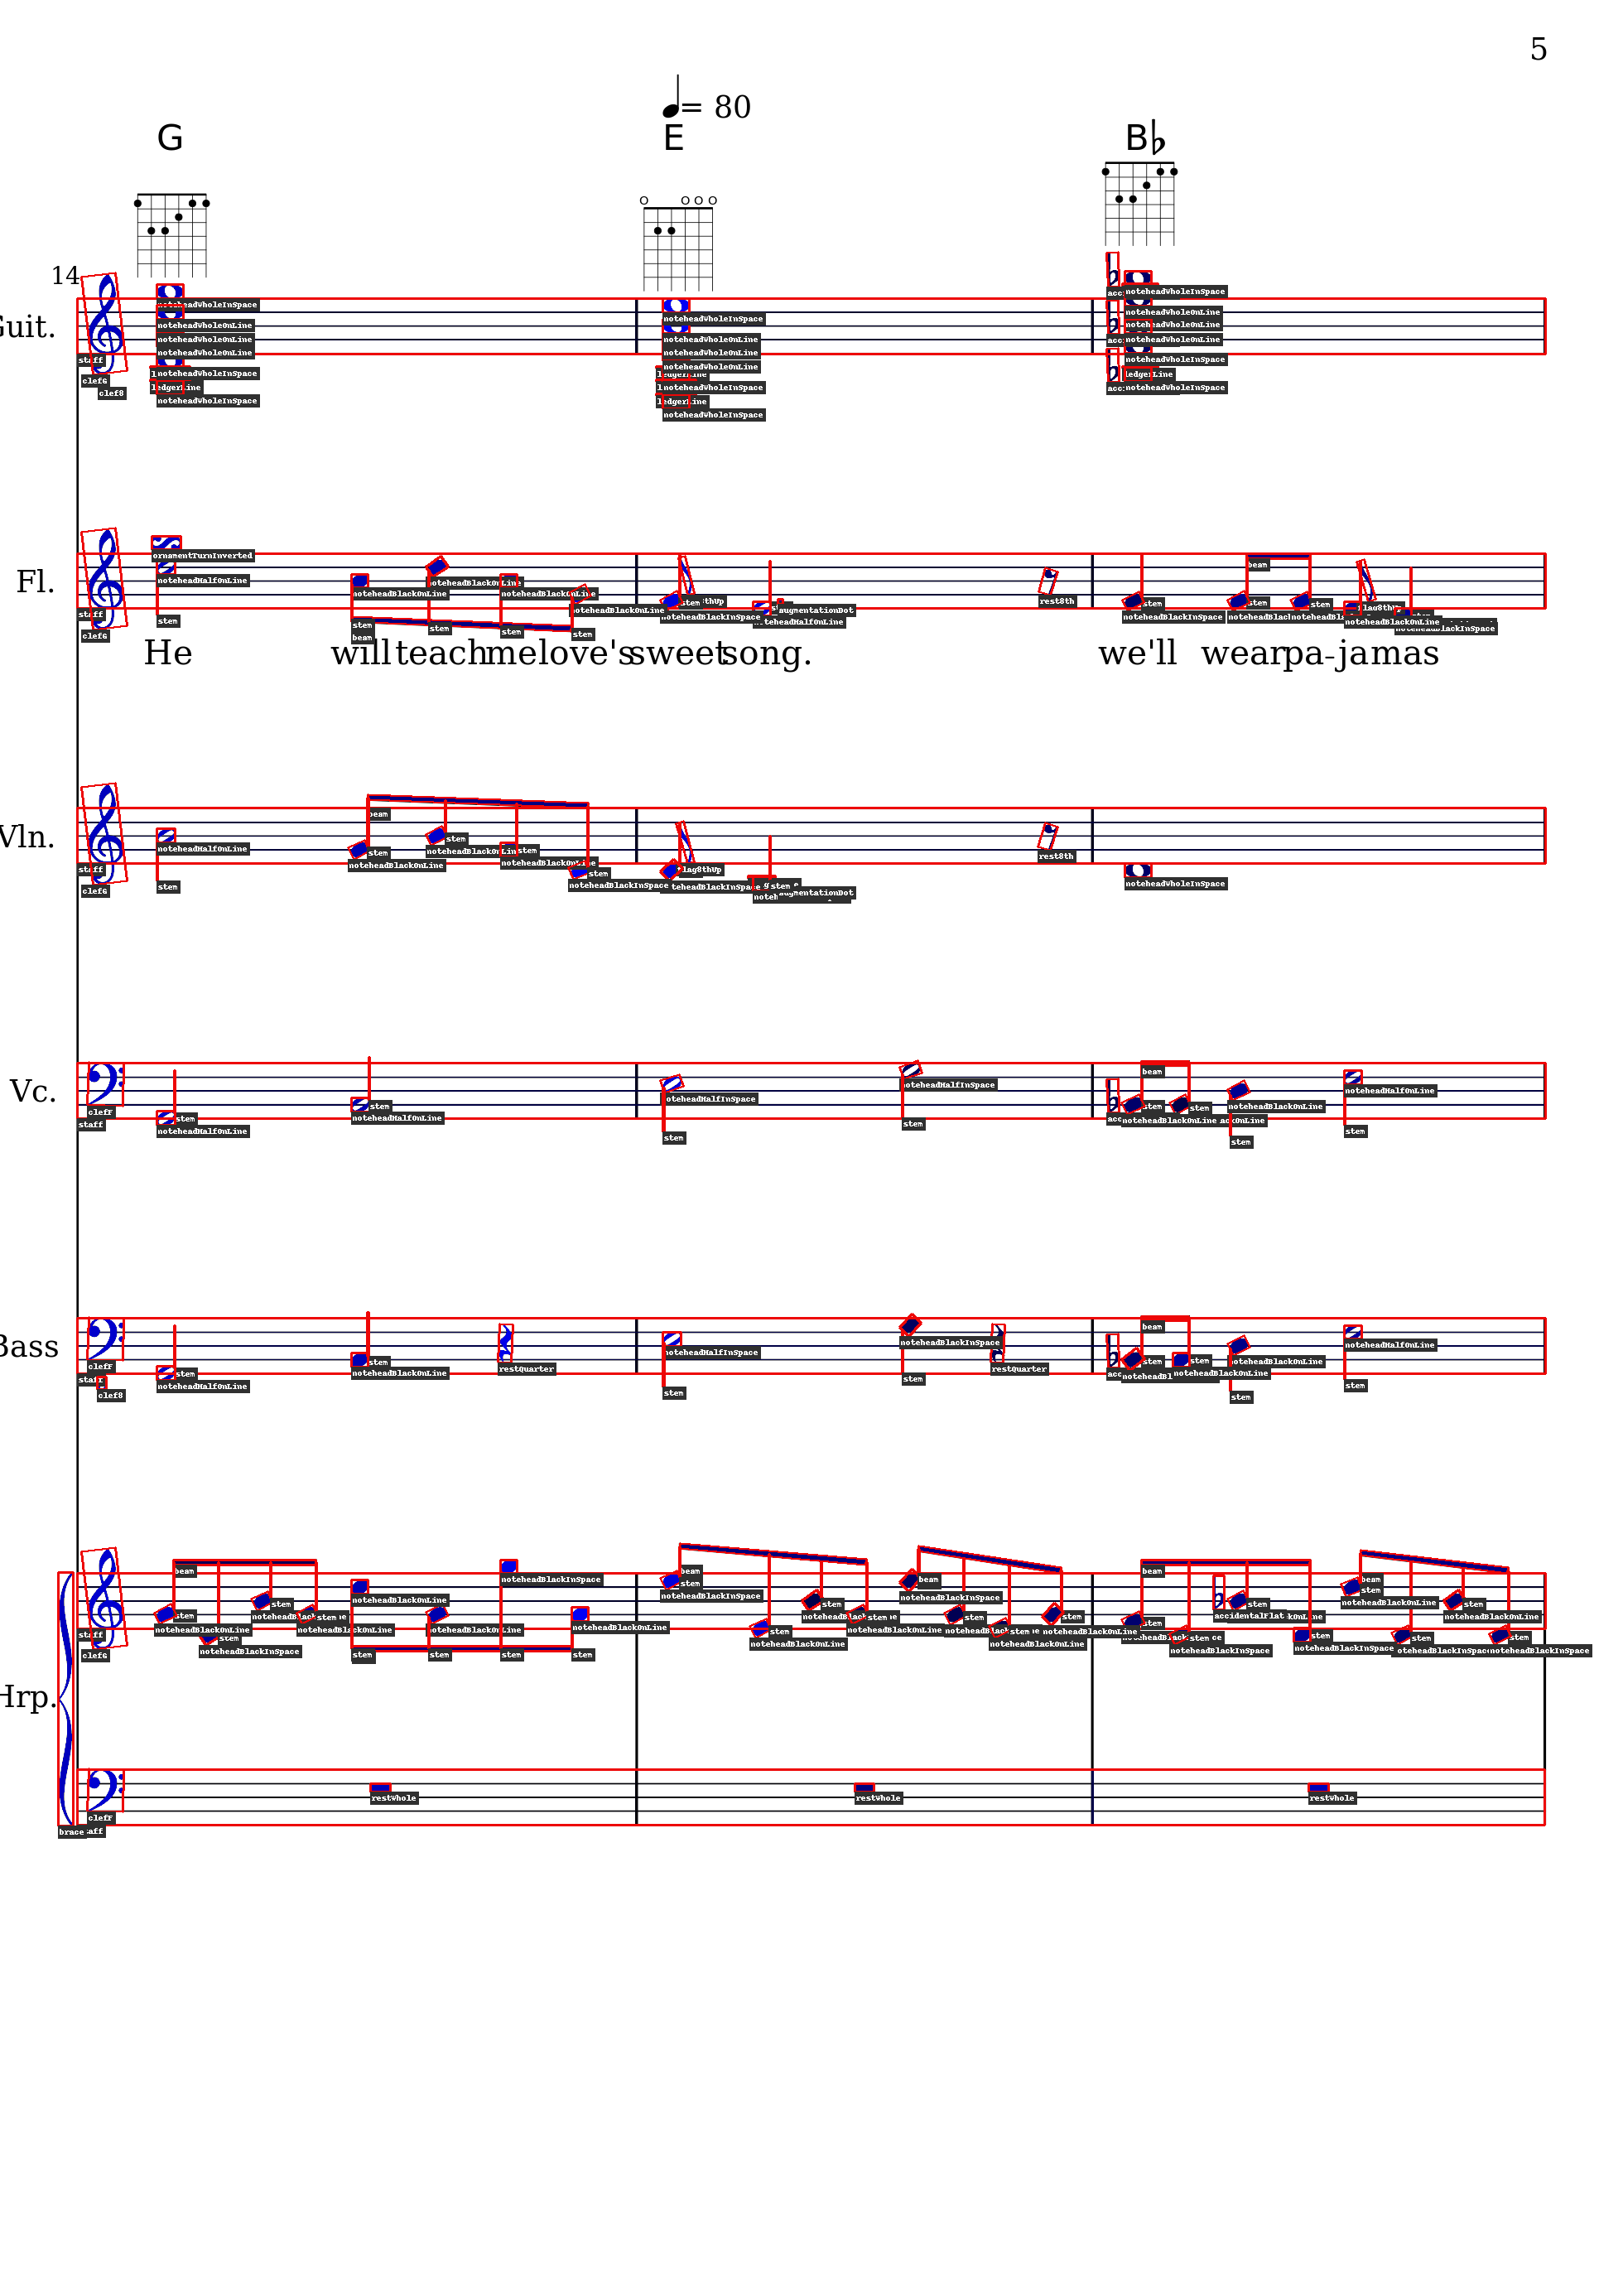

In [12]:
o.visualize(img_idx=1, show=True, instances=True)

In [41]:
datasamples = 50
img_idxs = [i for i in range(datasamples)]
imgs, anns = o.get_img_ann_pair(idxs=img_idxs)

x   = [] #training inputs
y = [] #training outputs

for i in imgs:
 x.append(i)


for j in anns:
  annotations = {}
  for ann in j.iloc():
    annotations[ann["cat_id"][0]] = ann["a_bbox"]
  y.append(annotations)

print("Loaded {} input-output training pairs".format(datasamples))

#testing
print(x[10])
print(y[10])

Loaded 50 input-output training pairs
{'id': 14, 'filename': 'lg-807626261169412112-aug-beethoven--page-3.png', 'width': 1960, 'height': 2772, 'ann_ids': ['772601', '772602', '772603', '772604', '772605', '772606', '772607', '772608', '772609', '772610', '772611', '772612', '772613', '772614', '772615', '772616', '772617', '772618', '772619', '772620', '772621', '772622', '772623', '772624', '772625', '772626', '772627', '772628', '772629', '772630', '772631', '772632', '772633', '772634', '772635', '772636', '772637', '772638', '772639', '772640', '772641', '772642', '772643', '772644', '772645', '772646', '772647', '772648', '772649', '772650', '772651', '772652', '772653', '772654', '772655', '772656', '772657', '772658', '772659', '772660', '772661', '772662', '772663', '772664', '772665', '772666', '772667', '772668', '772669', '772670', '772671', '772672', '772673', '772674', '772675', '772676', '772677', '772678', '772679', '772680', '772681', '772682', '772683', '772684', '7726

In [19]:
%cd images

/content/drive/My Drive/OpticalMusicRecognition/ds2_dense/images


In [20]:
from PIL import Image

filename = imgs[0]["filename"]
input_image = Image.open(filename)


# Extracting pixel map:
pixel_map = input_image.load()
  
# Extracting the width and height 
# of the image:
width, height = input_image.size


# taking half of the width:
for x in range(width):
    for y in range(height):
        
        if(x >= a_bbox[0] and x <= a_bbox[2] and y >= a_bbox[1] and y <= a_bbox[3]):
          pixel_map[x, y] = (255, 0, 0)


In [21]:
%cd ../..

/content/drive/My Drive/OpticalMusicRecognition


In [22]:
input_image.save("test2", format="png")

**Building the Model to Detect Staves**

In [44]:
import torch
from torchvision import datasets, io, models, ops, transforms, utils
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader

model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [46]:
num_classes = 135 + 1 # 135 Classes + 1 background

def collate_fn(batch):
    return tuple(zip(*batch))

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

train_data_loader = DataLoader(
    x,
    batch_size=5,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


In [52]:
%cd ds2_dense/images
%pwd

/content/drive/My Drive/OpticalMusicRecognition/ds2_dense/images


'/content/drive/My Drive/OpticalMusicRecognition/ds2_dense/images'

In [57]:
test1 = Image.open(x[0]["filename"])
out1 = {}
out1["boxes"] = y[0].values()
out1["labels"] = y[0].keys()
model(test1, out1)

TypeError: ignored

In [48]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  20 #Low epoch to save GPU time